In [22]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [23]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [24]:
!wget https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py -O tf_keras_model.py

--2022-06-16 21:17:50--  https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6795 (6.6K) [text/plain]
Saving to: ‘tf_keras_model.py’

tf_keras_model.py   100%[===================>]   6.64K  --.-KB/s    in 0s      

2022-06-16 21:17:51 (64.6 MB/s) - ‘tf_keras_model.py’ saved [6795/6795]



In [56]:
!wget https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/lr_finder.py -O lr_finder.py

--2022-06-16 21:36:05--  https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/lr_finder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815 [text/plain]
Saving to: ‘lr_finder.py’

lr_finder.py        100%[===================>]     815  --.-KB/s    in 0s      

2022-06-16 21:36:05 (55.0 MB/s) - ‘lr_finder.py’ saved [815/815]



In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# VANNO TUTTI CAMBIATI

# !wget https://www.dropbox.com/s/6s5khncrval4rz9/bkg_et.npy?dl=1 -o bkg_et.npy
# !wget https://www.dropbox.com/s/qc7z1nhqh5xvpbg/bkg_mask.npy?dl=1 -o bkg_mask.npy
# !wget https://www.dropbox.com/s/fs5e9wuhqtr66xh/bkg_xy.npy?dl=1 -o bkg_xy.npy
# !wget https://www.dropbox.com/s/w0b94xzyk2wg7y4/signal_et.npy?dl=1 -o signal_et.npy
# !wget https://www.dropbox.com/s/3k6b0u3zz65xnyf/signal_mask.npy?dl=1 -o signal_mask.npy
# !wget https://www.dropbox.com/s/chcep3q8terrj4k/signal_xy.npy?dl=1 -o signal_xy.npy

In [60]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net_lite_custom, edge_conv
from lr_finder import LRFind

In [61]:
data_folder = "/content/drive/MyDrive/datiML"

name_map = {"points": "xy", "features": "et", "mask": "mask", "summary": "etrn"} # va provato sia xy che rphi

signal  = {key: np.load(f"{data_folder}/signal_{ name_map[key]}.npy") for key in name_map}

mnbs    = {key: np.load(f"{data_folder}/mnbs_{   name_map[key]}.npy") for key in name_map}

cosmics = {key: np.load(f"{data_folder}/cosmics_{name_map[key]}.npy") for key in name_map}

In [62]:
S =  signal["mask"].shape[0] #entries segnale
F =    mnbs["mask"].shape[0] #entries mnbs (background flash da fascio)
C = cosmics["mask"].shape[0] #entries cosmici

N = S + F + C

p = np.random.permutation(N) #

In [63]:
'''
cluster su disco 0 in un injection cycle (1.33s):
RMC: 330
MNBS: 1.3M
cosmici: 4

cluster simulati su disco 0:
RMC: 150k
MNBS: 1.05M
cosmici: 53k

pesi:
RMC: 66/150k 
MNBS: 
Cosmici: 4/53k
'''

signal_weight = 330/150e3 * 100
mnbs_weight = 0.24 * 100
cosmics_weight = 4/53e3 * 100

'''
il campione MC è stato filtrato con ROOT
effettuando due tagli di preselezione:
E del cluster > 50 MeV  &&  R del centroide del cluster > 480 mm
'''

print(end="")

In [64]:
data = {key: np.concatenate( (signal[key], mnbs[key], cosmics[key]) )[p] for key in name_map}

label_list = [1, 0, 0]
entries_list = [S, F, C]
weight_list = [signal_weight, mnbs_weight, cosmics_weight]

print(f"- Entries per signale, mnbs e cosmici:{entries_list}")
print(f"- Pesi per signale, mnbs e cosmici:{weight_list}")

label = np.concatenate( 
    [ np.ones((e))*l for e, l in zip(entries_list,  label_list) ]
)[p]

sample_weight = np.concatenate( 
    [ np.ones((e))*w for e, w in zip(entries_list, weight_list) ]
)[p]

- Entries per signale, mnbs e cosmici:[41372, 1132, 41598]
- Pesi per signale, mnbs e cosmici:[0.22, 24.0, 0.007547169811320755]


In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for key in ["points", "features"]:
  data[key][data["mask"].reshape(N, 50)] = scaler.fit_transform(data[key][data["mask"].reshape(N, 50)])

data["summary"] = scaler.fit_transform(data["summary"])

In [66]:
train_data  = {key: data[key][int(N*0.0) : int(N*0.7)] for key in name_map}
test_data   = {key: data[key][int(N*0.7) : int(N*0.9)] for key in name_map}
val_data    = {key: data[key][int(N*0.9) : int(N*1.0)] for key in name_map}

train_label = label[int(N*0.0) : int(N*0.7)]
test_label  = label[int(N*0.7) : int(N*0.9)]
val_label   = label[int(N*0.9) : int(N*1.0)]

train_weight = sample_weight[int(N*0.0) : int(N*0.7)]
test_weight  = sample_weight[int(N*0.7) : int(N*0.9)]
val_weight   = sample_weight[int(N*0.9) : int(N*1.0)]

In [84]:
input_shapes = {'points': (50, 2), 'features': (50, 2), 'mask':(50, 1)}

model = get_particle_net_lite_custom(num_classes, input_shapes)

In [68]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 30

In [85]:
def lr_schedule(epoch):
    lr = 1e-2
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [86]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

[2022-06-16 21:45:05,867] INFO: Learning rate: 0.010000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 50, 1)]      0           []                               
                                                                                                  
 tf.math.not_equal_3 (TFOpLambd  (None, 50, 1)       0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_6 (TFOpLambda)         (None, 50, 1)        0           ['tf.math.not_equal_3[0][0]']    
                                                                                                  
 tf.math.equal_3 (TFOpLambda)   (None, 50, 1)        0           ['tf.cast_6[0][0]']    

In [87]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
'''
lr_finder_steps = 400
lr_find = LRFind(1e-6, 1e1, lr_finder_steps)
'''
callbacks = [checkpoint, progress_bar, lr_scheduler]

In [88]:
history = model.fit(
    [train_data["points"], train_data["features"], train_data["mask"], train_data["summary"]], 
    train_label,
    batch_size=batch_size,
    epochs=40,
    validation_data=(
      [val_data["points"], val_data["features"], val_data["mask"], val_data["summary"]], 
      val_label, val_weight
    ),
    shuffle=True,
    sample_weight=train_weight,
    callbacks=callbacks,
)


Epoch 1/40


[2022-06-16 21:45:20,929] INFO: Learning rate: 0.010000


      0/Unknown - 10s 0s/sample - loss: 0.1336 - accuracy: 0.6147 - precision_3: 0.6089 - recall_3: 0.6127
Epoch 1: val_accuracy improved from -inf to 0.67055, saving model to model_checkpoints/particle_net_lite_model.001.h5
58/58 [==============================] - 14s 233ms/sample - loss: 0.1336 - accuracy: 0.6147 - precision_3: 0.6089 - recall_3: 0.6127 - val_loss: 0.1620 - val_accuracy: 0.6706 - val_precision_3: 0.6443 - val_recall_3: 0.7089
Epoch 2/40


[2022-06-16 21:45:34,446] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0893 - accuracy: 0.7090 - precision_3: 0.6686 - recall_3: 0.8137
Epoch 2: val_accuracy did not improve from 0.67055
58/58 [==============================] - 10s 168ms/sample - loss: 0.0893 - accuracy: 0.7090 - precision_3: 0.6686 - recall_3: 0.8137 - val_loss: 0.1475 - val_accuracy: 0.5653 - val_precision_3: 0.5693 - val_recall_3: 0.4089
Epoch 3/40


[2022-06-16 21:45:44,191] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0787 - accuracy: 0.7041 - precision_3: 0.6613 - recall_3: 0.8209
Epoch 3: val_accuracy improved from 0.67055 to 0.75805, saving model to model_checkpoints/particle_net_lite_model.003.h5
58/58 [==============================] - 10s 171ms/sample - loss: 0.0787 - accuracy: 0.7041 - precision_3: 0.6613 - recall_3: 0.8209 - val_loss: 0.0842 - val_accuracy: 0.7581 - val_precision_3: 0.7169 - val_recall_3: 0.8241
Epoch 4/40


[2022-06-16 21:45:54,122] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0746 - accuracy: 0.7722 - precision_3: 0.7287 - recall_3: 0.8579
Epoch 4: val_accuracy improved from 0.75805 to 0.77839, saving model to model_checkpoints/particle_net_lite_model.004.h5
58/58 [==============================] - 10s 168ms/sample - loss: 0.0746 - accuracy: 0.7722 - precision_3: 0.7287 - recall_3: 0.8579 - val_loss: 0.0621 - val_accuracy: 0.7784 - val_precision_3: 0.7342 - val_recall_3: 0.8478
Epoch 5/40


[2022-06-16 21:46:03,902] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0636 - accuracy: 0.7943 - precision_3: 0.7497 - recall_3: 0.8756
Epoch 5: val_accuracy improved from 0.77839 to 0.80442, saving model to model_checkpoints/particle_net_lite_model.005.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0636 - accuracy: 0.7943 - precision_3: 0.7497 - recall_3: 0.8756 - val_loss: 0.0577 - val_accuracy: 0.8044 - val_precision_3: 0.7376 - val_recall_3: 0.9234
Epoch 6/40


[2022-06-16 21:46:13,545] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0611 - accuracy: 0.8046 - precision_3: 0.7579 - recall_3: 0.8875
Epoch 6: val_accuracy improved from 0.80442 to 0.85519, saving model to model_checkpoints/particle_net_lite_model.006.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0611 - accuracy: 0.8046 - precision_3: 0.7579 - recall_3: 0.8875 - val_loss: 0.1931 - val_accuracy: 0.8552 - val_precision_3: 0.7943 - val_recall_3: 0.9446
Epoch 7/40


[2022-06-16 21:46:23,180] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0612 - accuracy: 0.8316 - precision_3: 0.7957 - recall_3: 0.8865
Epoch 7: val_accuracy did not improve from 0.85519
58/58 [==============================] - 9s 163ms/sample - loss: 0.0612 - accuracy: 0.8316 - precision_3: 0.7957 - recall_3: 0.8865 - val_loss: 0.0582 - val_accuracy: 0.8507 - val_precision_3: 0.8268 - val_recall_3: 0.8736
Epoch 8/40


[2022-06-16 21:46:32,660] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0621 - accuracy: 0.8373 - precision_3: 0.8105 - recall_3: 0.8751
Epoch 8: val_accuracy improved from 0.85519 to 0.87516, saving model to model_checkpoints/particle_net_lite_model.008.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0621 - accuracy: 0.8373 - precision_3: 0.8105 - recall_3: 0.8751 - val_loss: 0.0705 - val_accuracy: 0.8752 - val_precision_3: 0.8272 - val_recall_3: 0.9372
Epoch 9/40


[2022-06-16 21:46:42,257] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0518 - accuracy: 0.8637 - precision_3: 0.8341 - recall_3: 0.9035
Epoch 9: val_accuracy improved from 0.87516 to 0.90358, saving model to model_checkpoints/particle_net_lite_model.009.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0518 - accuracy: 0.8637 - precision_3: 0.8341 - recall_3: 0.9035 - val_loss: 0.0643 - val_accuracy: 0.9036 - val_precision_3: 0.8784 - val_recall_3: 0.9288
Epoch 10/40


[2022-06-16 21:46:51,881] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0545 - accuracy: 0.8681 - precision_3: 0.8457 - recall_3: 0.8961
Epoch 10: val_accuracy did not improve from 0.90358
58/58 [==============================] - 9s 164ms/sample - loss: 0.0545 - accuracy: 0.8681 - precision_3: 0.8457 - recall_3: 0.8961 - val_loss: 0.0496 - val_accuracy: 0.8798 - val_precision_3: 0.8636 - val_recall_3: 0.8919
Epoch 11/40


[2022-06-16 21:47:01,402] INFO: Learning rate: 0.010000


 0/58 [..............................] - ETA: 0s - loss: 0.0501 - accuracy: 0.8782 - precision_3: 0.8546 - recall_3: 0.9077
Epoch 11: val_accuracy did not improve from 0.90358
58/58 [==============================] - 10s 165ms/sample - loss: 0.0501 - accuracy: 0.8782 - precision_3: 0.8546 - recall_3: 0.9077 - val_loss: 0.0495 - val_accuracy: 0.8993 - val_precision_3: 0.8749 - val_recall_3: 0.9234
Epoch 12/40


[2022-06-16 21:47:10,967] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0444 - accuracy: 0.8834 - precision_3: 0.8583 - recall_3: 0.9148
Epoch 12: val_accuracy improved from 0.90358 to 0.90572, saving model to model_checkpoints/particle_net_lite_model.012.h5
58/58 [==============================] - 10s 167ms/sample - loss: 0.0444 - accuracy: 0.8834 - precision_3: 0.8583 - recall_3: 0.9148 - val_loss: 0.0491 - val_accuracy: 0.9057 - val_precision_3: 0.8713 - val_recall_3: 0.9441
Epoch 13/40


[2022-06-16 21:47:20,649] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0402 - accuracy: 0.8919 - precision_3: 0.8604 - recall_3: 0.9322
Epoch 13: val_accuracy improved from 0.90572 to 0.90655, saving model to model_checkpoints/particle_net_lite_model.013.h5
58/58 [==============================] - 10s 167ms/sample - loss: 0.0402 - accuracy: 0.8919 - precision_3: 0.8604 - recall_3: 0.9322 - val_loss: 0.0475 - val_accuracy: 0.9066 - val_precision_3: 0.8772 - val_recall_3: 0.9377
Epoch 14/40


[2022-06-16 21:47:30,342] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0405 - accuracy: 0.8936 - precision_3: 0.8682 - recall_3: 0.9248
Epoch 14: val_accuracy improved from 0.90655 to 0.90762, saving model to model_checkpoints/particle_net_lite_model.014.h5
58/58 [==============================] - 10s 167ms/sample - loss: 0.0405 - accuracy: 0.8936 - precision_3: 0.8682 - recall_3: 0.9248 - val_loss: 0.0462 - val_accuracy: 0.9076 - val_precision_3: 0.8799 - val_recall_3: 0.9365
Epoch 15/40


[2022-06-16 21:47:40,007] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0401 - accuracy: 0.8947 - precision_3: 0.8693 - recall_3: 0.9257
Epoch 15: val_accuracy did not improve from 0.90762
58/58 [==============================] - 10s 164ms/sample - loss: 0.0401 - accuracy: 0.8947 - precision_3: 0.8693 - recall_3: 0.9257 - val_loss: 0.0460 - val_accuracy: 0.9060 - val_precision_3: 0.8811 - val_recall_3: 0.9308
Epoch 16/40


[2022-06-16 21:47:49,562] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0376 - accuracy: 0.8996 - precision_3: 0.8718 - recall_3: 0.9338
Epoch 16: val_accuracy improved from 0.90762 to 0.91214, saving model to model_checkpoints/particle_net_lite_model.016.h5
58/58 [==============================] - 10s 169ms/sample - loss: 0.0376 - accuracy: 0.8996 - precision_3: 0.8718 - recall_3: 0.9338 - val_loss: 0.0464 - val_accuracy: 0.9121 - val_precision_3: 0.8861 - val_recall_3: 0.9387
Epoch 17/40


[2022-06-16 21:47:59,359] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0390 - accuracy: 0.8988 - precision_3: 0.8735 - recall_3: 0.9296
Epoch 17: val_accuracy improved from 0.91214 to 0.91499, saving model to model_checkpoints/particle_net_lite_model.017.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0390 - accuracy: 0.8988 - precision_3: 0.8735 - recall_3: 0.9296 - val_loss: 0.0478 - val_accuracy: 0.9150 - val_precision_3: 0.8869 - val_recall_3: 0.9443
Epoch 18/40


[2022-06-16 21:48:08,972] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0356 - accuracy: 0.9041 - precision_3: 0.8767 - recall_3: 0.9375
Epoch 18: val_accuracy improved from 0.91499 to 0.91654, saving model to model_checkpoints/particle_net_lite_model.018.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0356 - accuracy: 0.9041 - precision_3: 0.8767 - recall_3: 0.9375 - val_loss: 0.0471 - val_accuracy: 0.9165 - val_precision_3: 0.8867 - val_recall_3: 0.9483
Epoch 19/40


[2022-06-16 21:48:18,622] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0354 - accuracy: 0.9024 - precision_3: 0.8770 - recall_3: 0.9332
Epoch 19: val_accuracy did not improve from 0.91654
58/58 [==============================] - 10s 164ms/sample - loss: 0.0354 - accuracy: 0.9024 - precision_3: 0.8770 - recall_3: 0.9332 - val_loss: 0.0444 - val_accuracy: 0.9096 - val_precision_3: 0.8877 - val_recall_3: 0.9305
Epoch 20/40


[2022-06-16 21:48:28,162] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0362 - accuracy: 0.9052 - precision_3: 0.8788 - recall_3: 0.9373
Epoch 20: val_accuracy did not improve from 0.91654
58/58 [==============================] - 10s 165ms/sample - loss: 0.0362 - accuracy: 0.9052 - precision_3: 0.8788 - recall_3: 0.9373 - val_loss: 0.0456 - val_accuracy: 0.9133 - val_precision_3: 0.8867 - val_recall_3: 0.9406
Epoch 21/40


[2022-06-16 21:48:37,718] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0357 - accuracy: 0.9054 - precision_3: 0.8801 - recall_3: 0.9359
Epoch 21: val_accuracy did not improve from 0.91654
58/58 [==============================] - 10s 164ms/sample - loss: 0.0357 - accuracy: 0.9054 - precision_3: 0.8801 - recall_3: 0.9359 - val_loss: 0.0460 - val_accuracy: 0.9011 - val_precision_3: 0.8882 - val_recall_3: 0.9096
Epoch 22/40


[2022-06-16 21:48:47,249] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0357 - accuracy: 0.9045 - precision_3: 0.8812 - recall_3: 0.9322
Epoch 22: val_accuracy did not improve from 0.91654
58/58 [==============================] - 10s 165ms/sample - loss: 0.0357 - accuracy: 0.9045 - precision_3: 0.8812 - recall_3: 0.9322 - val_loss: 0.0459 - val_accuracy: 0.9070 - val_precision_3: 0.8914 - val_recall_3: 0.9195
Epoch 23/40


[2022-06-16 21:48:56,855] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0346 - accuracy: 0.9063 - precision_3: 0.8811 - recall_3: 0.9365
Epoch 23: val_accuracy did not improve from 0.91654
58/58 [==============================] - 10s 166ms/sample - loss: 0.0346 - accuracy: 0.9063 - precision_3: 0.8811 - recall_3: 0.9365 - val_loss: 0.0456 - val_accuracy: 0.9156 - val_precision_3: 0.8947 - val_recall_3: 0.9352
Epoch 24/40


[2022-06-16 21:49:06,478] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0330 - accuracy: 0.9075 - precision_3: 0.8816 - recall_3: 0.9386
Epoch 24: val_accuracy improved from 0.91654 to 0.92236, saving model to model_checkpoints/particle_net_lite_model.024.h5
58/58 [==============================] - 10s 167ms/sample - loss: 0.0330 - accuracy: 0.9075 - precision_3: 0.8816 - recall_3: 0.9386 - val_loss: 0.0483 - val_accuracy: 0.9224 - val_precision_3: 0.8933 - val_recall_3: 0.9530
Epoch 25/40


[2022-06-16 21:49:16,190] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0337 - accuracy: 0.9094 - precision_3: 0.8844 - recall_3: 0.9393
Epoch 25: val_accuracy improved from 0.92236 to 0.92569, saving model to model_checkpoints/particle_net_lite_model.025.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0337 - accuracy: 0.9094 - precision_3: 0.8844 - recall_3: 0.9393 - val_loss: 0.0511 - val_accuracy: 0.9257 - val_precision_3: 0.8958 - val_recall_3: 0.9574
Epoch 26/40


[2022-06-16 21:49:25,849] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0340 - accuracy: 0.9080 - precision_3: 0.8836 - recall_3: 0.9371
Epoch 26: val_accuracy did not improve from 0.92569
58/58 [==============================] - 10s 165ms/sample - loss: 0.0340 - accuracy: 0.9080 - precision_3: 0.8836 - recall_3: 0.9371 - val_loss: 0.0457 - val_accuracy: 0.9207 - val_precision_3: 0.8967 - val_recall_3: 0.9446
Epoch 27/40


[2022-06-16 21:49:35,416] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0322 - accuracy: 0.9122 - precision_3: 0.8856 - recall_3: 0.9439
Epoch 27: val_accuracy did not improve from 0.92569
58/58 [==============================] - 10s 164ms/sample - loss: 0.0322 - accuracy: 0.9122 - precision_3: 0.8856 - recall_3: 0.9439 - val_loss: 0.0475 - val_accuracy: 0.9188 - val_precision_3: 0.8991 - val_recall_3: 0.9369
Epoch 28/40


[2022-06-16 21:49:44,946] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0322 - accuracy: 0.9116 - precision_3: 0.8859 - recall_3: 0.9422
Epoch 28: val_accuracy did not improve from 0.92569
58/58 [==============================] - 9s 164ms/sample - loss: 0.0322 - accuracy: 0.9116 - precision_3: 0.8859 - recall_3: 0.9422 - val_loss: 0.0485 - val_accuracy: 0.9211 - val_precision_3: 0.8965 - val_recall_3: 0.9456
Epoch 29/40


[2022-06-16 21:49:54,446] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0317 - accuracy: 0.9101 - precision_3: 0.8859 - recall_3: 0.9386
Epoch 29: val_accuracy did not improve from 0.92569
58/58 [==============================] - 9s 164ms/sample - loss: 0.0317 - accuracy: 0.9101 - precision_3: 0.8859 - recall_3: 0.9386 - val_loss: 0.0492 - val_accuracy: 0.9149 - val_precision_3: 0.8955 - val_recall_3: 0.9325
Epoch 30/40


[2022-06-16 21:50:03,950] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0322 - accuracy: 0.9128 - precision_3: 0.8878 - recall_3: 0.9425
Epoch 30: val_accuracy did not improve from 0.92569
58/58 [==============================] - 10s 164ms/sample - loss: 0.0322 - accuracy: 0.9128 - precision_3: 0.8878 - recall_3: 0.9425 - val_loss: 0.0503 - val_accuracy: 0.9023 - val_precision_3: 0.8958 - val_recall_3: 0.9025
Epoch 31/40


[2022-06-16 21:50:13,479] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0321 - accuracy: 0.9115 - precision_3: 0.8897 - recall_3: 0.9368
Epoch 31: val_accuracy did not improve from 0.92569
58/58 [==============================] - 10s 165ms/sample - loss: 0.0321 - accuracy: 0.9115 - precision_3: 0.8897 - recall_3: 0.9368 - val_loss: 0.0506 - val_accuracy: 0.9182 - val_precision_3: 0.8971 - val_recall_3: 0.9382
Epoch 32/40


[2022-06-16 21:50:23,047] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0309 - accuracy: 0.9119 - precision_3: 0.8888 - recall_3: 0.9389
Epoch 32: val_accuracy did not improve from 0.92569
58/58 [==============================] - 10s 164ms/sample - loss: 0.0309 - accuracy: 0.9119 - precision_3: 0.8888 - recall_3: 0.9389 - val_loss: 0.0481 - val_accuracy: 0.9164 - val_precision_3: 0.8965 - val_recall_3: 0.9347
Epoch 33/40


[2022-06-16 21:50:32,595] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0321 - accuracy: 0.9130 - precision_3: 0.8893 - recall_3: 0.9408
Epoch 33: val_accuracy improved from 0.92569 to 0.92688, saving model to model_checkpoints/particle_net_lite_model.033.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0321 - accuracy: 0.9130 - precision_3: 0.8893 - recall_3: 0.9408 - val_loss: 0.0534 - val_accuracy: 0.9269 - val_precision_3: 0.9005 - val_recall_3: 0.9539
Epoch 34/40


[2022-06-16 21:50:42,228] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0310 - accuracy: 0.9139 - precision_3: 0.8904 - recall_3: 0.9415
Epoch 34: val_accuracy did not improve from 0.92688
58/58 [==============================] - 9s 164ms/sample - loss: 0.0310 - accuracy: 0.9139 - precision_3: 0.8904 - recall_3: 0.9415 - val_loss: 0.0478 - val_accuracy: 0.9102 - val_precision_3: 0.9002 - val_recall_3: 0.9155
Epoch 35/40


[2022-06-16 21:50:51,723] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0329 - accuracy: 0.9117 - precision_3: 0.8906 - recall_3: 0.9362
Epoch 35: val_accuracy did not improve from 0.92688
58/58 [==============================] - 10s 166ms/sample - loss: 0.0329 - accuracy: 0.9117 - precision_3: 0.8906 - recall_3: 0.9362 - val_loss: 0.0511 - val_accuracy: 0.9077 - val_precision_3: 0.8949 - val_recall_3: 0.9165
Epoch 36/40


[2022-06-16 21:51:01,370] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0307 - accuracy: 0.9162 - precision_3: 0.8919 - recall_3: 0.9446
Epoch 36: val_accuracy did not improve from 0.92688
58/58 [==============================] - 10s 164ms/sample - loss: 0.0307 - accuracy: 0.9162 - precision_3: 0.8919 - recall_3: 0.9446 - val_loss: 0.0522 - val_accuracy: 0.9268 - val_precision_3: 0.9020 - val_recall_3: 0.9517
Epoch 37/40


[2022-06-16 21:51:10,913] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0325 - accuracy: 0.9135 - precision_3: 0.8907 - recall_3: 0.9402
Epoch 37: val_accuracy did not improve from 0.92688
58/58 [==============================] - 10s 164ms/sample - loss: 0.0325 - accuracy: 0.9135 - precision_3: 0.8907 - recall_3: 0.9402 - val_loss: 0.0447 - val_accuracy: 0.9193 - val_precision_3: 0.8971 - val_recall_3: 0.9406
Epoch 38/40


[2022-06-16 21:51:20,460] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0321 - accuracy: 0.9105 - precision_3: 0.8881 - recall_3: 0.9368
Epoch 38: val_accuracy did not improve from 0.92688
58/58 [==============================] - 10s 164ms/sample - loss: 0.0321 - accuracy: 0.9105 - precision_3: 0.8881 - recall_3: 0.9368 - val_loss: 0.0500 - val_accuracy: 0.9241 - val_precision_3: 0.9011 - val_recall_3: 0.9468
Epoch 39/40


[2022-06-16 21:51:30,007] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0311 - accuracy: 0.9174 - precision_3: 0.8931 - recall_3: 0.9459
Epoch 39: val_accuracy did not improve from 0.92688
58/58 [==============================] - 10s 164ms/sample - loss: 0.0311 - accuracy: 0.9174 - precision_3: 0.8931 - recall_3: 0.9459 - val_loss: 0.0492 - val_accuracy: 0.9238 - val_precision_3: 0.9006 - val_recall_3: 0.9466
Epoch 40/40


[2022-06-16 21:51:39,554] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0317 - accuracy: 0.9113 - precision_3: 0.8915 - recall_3: 0.9338
Epoch 40: val_accuracy did not improve from 0.92688
58/58 [==============================] - 10s 164ms/sample - loss: 0.0317 - accuracy: 0.9113 - precision_3: 0.8915 - recall_3: 0.9338 - val_loss: 0.0500 - val_accuracy: 0.9202 - val_precision_3: 0.8986 - val_recall_3: 0.9409


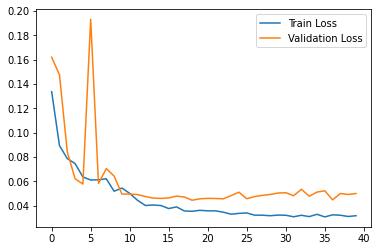

In [89]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

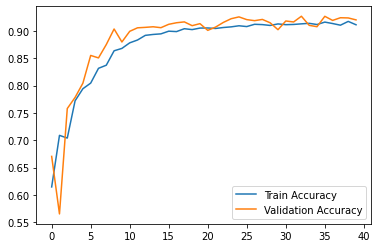

In [91]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()

In [92]:
plt.plot(history.history['precision_3'], label="Train Purity")
plt.plot(history.history['val_precision_3'], label="Validation Purity")
plt.legend()

KeyError: ignored

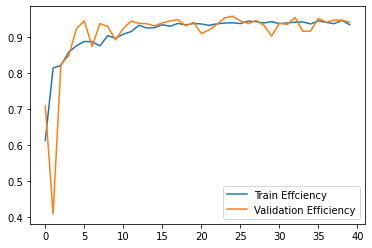

In [93]:
plt.plot(history.history['recall_3'], label="Train Effciency")
plt.plot(history.history['val_recall_3'], label="Validation Efficiency")
plt.legend()

In [101]:
!ls -1rt model_checkpoints/*model*.h5 | tail -n 1
!cp $(ls -1rt model_checkpoints/*model*.h5 | tail -n 1) model_checkpoints/last.h5

model_checkpoints/particle_net_lite_model.033.h5


In [102]:
model.load_weights("model_checkpoints/last.h5")

In [103]:
probs = model.predict_on_batch(test_data)

0.9778539234569689


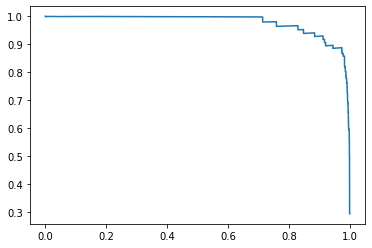

In [104]:
precision, recall, thresholds = precision_recall_curve(test_label, probs, sample_weight=test_weight)
plt.plot(recall, precision)
print(auc(recall, precision))